# Predicting the Helpfulness of Amazon Reviews - Cellphones and Accessories Category

## Import Libraries

In [10]:
# load packages
import gzip
import json
import os
import wget

import random
import string

import numpy as np
import pandas as pd

import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords 
from nltk.stem import PorterStemmer
# this nltk download may be needed. download stopwords, punkt
# nltk.download()

import sklearn
from sklearn import preprocessing
from sklearn.feature_extraction.text import *
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Load and Prepare Dataset

In [11]:
# load dataset - download directly from source, save to data directory

file_name = "data/reviews_Cell_Phones_and_Accessories_5.json.gz"
output_dir = "data"
url = "http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Cell_Phones_and_Accessories_5.json.gz"

if not os.path.isdir(output_dir):
    os.makedirs(output_dir)

if not os.path.isfile(file_name):
    file_name = wget.download(url, out=output_dir)

In [21]:
# helper functions to parse data from compressed json into pandas DF
def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield eval(l)

def get_dataframe(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')


# helper function to pull out total helpful votes
def get_helpful_votes(helpful):
    [helpful, total] = helpful
    return helpful


# helper function to pull out total votes (helpful and unhelpful)
def get_total_votes(helpful):
    [helpful, total] = helpful
    return total
    
    
# helper function to calculate helpfulness percentage 
def calculate_helpful_perc(helpful):
    [helpful, total] = helpful
    if total == 0:
        return 0
    else:
        return (helpful/total)

# helper function to return a df of only and equally-balanced zero and one hundred percent helpful percentages
def ones_and_zeroes_df(df):
    df_zeroes = df[df.helpful_perc == 0]
    len_zero = len(df_zeroes)
    
    df_ones = df[df.helpful_perc == 1]
    len_one = len(df_ones)
    
    min_len = min(len_zero, len_one)
    
    df_ones = df.sample(min_len)
    df_zeroes = df.sample(min_len)
    
    df = df_ones.append(df_zeroes, ignore_index=True)
    return df

In [22]:
# create dataframe
df = get_dataframe(file_name)

# parse helpful column into new columns of helpful_votes, total_votes, helpful_perc
df['helpful_votes'] = df['helpful'].apply(get_helpful_votes)
df['total_votes'] = df['helpful'].apply(get_total_votes)
df['helpful_perc'] = df['helpful'].apply(calculate_helpful_perc)

## Exploratory Data Analysis

### Data Insights

In [23]:
# take a look at the shape of the data
df.shape

(194439, 12)

In [24]:
# take a look at a sample of rows
df.sample(5)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,helpful_votes,total_votes,helpful_perc
93558,A1ZSX42Q9RAEVF,B00891F4ZS,Stephanie Seymore,"[0, 0]",I received product in a timely manner and in g...,5.0,Great product for a great price,1355184000,"12 11, 2012",0,0,0.0
188981,A58F10T4OE58C,B00HWX16GU,"S. Montgomery ""green dad""","[0, 0]",Or house was ina virtual ATT dead zone. We cou...,4.0,Solved our cell dead zone issues,1403654400,"06 25, 2014",0,0,0.0
10508,A1M9OT024TYW99,B002D4IHYM,Colorado Guy,"[0, 2]",This battery charger is a excellent solution a...,4.0,Great solution for back up power,1348444800,"09 24, 2012",0,2,0.0
13846,A2PS16JA81FYY,B0030HW0R6,Diana Vasquez,"[0, 0]",awesome deal for so many colors... just as wha...,5.0,Five Stars,1404950400,"07 10, 2014",0,0,0.0
62227,ANPWK0UIQ5B21,B005VNJH7I,Nickolaus Benson,"[0, 0]",My wife ordered this hoping it would be good f...,3.0,Too big for a girl,1387238400,"12 17, 2013",0,0,0.0


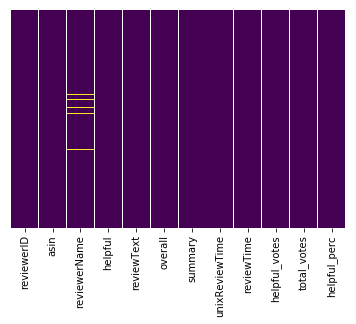

In [25]:
# see if there are any missing values by feature
# missing values show up in yellow
sns.heatmap(df.isnull(),cbar=False,yticklabels=False,cmap = 'viridis')

In [26]:
# calculate how many values are missing by feature
missing_df = pd.DataFrame(df.isnull().sum())
missing_df

,0
reviewerID,0
asin,0
reviewerName,3519
helpful,0
reviewText,0
overall,0
summary,0
unixReviewTime,0
reviewTime,0
helpful_votes,0


### Summary Statistics

In [27]:
# take a look at summary statistics of dataset
df.describe()

,overall,unixReviewTime,helpful_votes,total_votes,helpful_perc
count,194439.000000,1.944390e+05,194439.000000,194439.000000,194439.000000
mean,4.129912,1.368714e+09,1.437741,1.737043,0.193055
std,1.222499,3.230032e+07,15.857623,16.800879,0.372417
min,1.000000,9.828000e+08,0.000000,0.000000,0.000000
25%,4.000000,1.357603e+09,0.000000,0.000000,0.000000
50%,5.000000,1.374538e+09,0.000000,0.000000,0.000000
75%,5.000000,1.390262e+09,0.000000,1.000000,0.000000
max,5.000000,1.406074e+09,1984.000000,2031.000000,1.000000


### Examining the Target Variable

Text(0.5,1,'Histogram of Helpful Percentages')

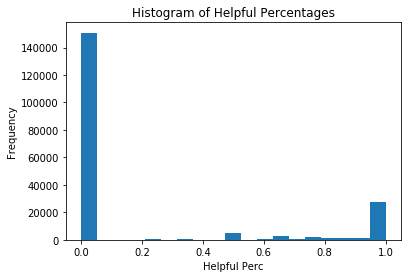

In [28]:
# look at distribution of helpful_perc
fig1 = plt.figure()
ax1 = fig1.add_subplot(1, 1, 1)
n, bins, patches = ax1.hist(x=df['helpful_perc'], bins='auto')
                                 
ax1.set_xlabel('Helpful Perc')
ax1.set_ylabel('Frequency')
ax1.set_title('Histogram of Helpful Percentages')

### Data Cleaning

In [20]:
# subset df of reviews that have at least three votes
df_three = df[df.total_votes >= 3]

# subset df of reviews that have two both and both are in agreeement
df_two = df[((df.total_votes == 2) & (df.helpful_perc == 1)) | ((df.total_votes == 2) & (df.helpful_perc == 0))]

# combine the dfs back together
df = df_three.append(df_two, ignore_index=True)
df.shape

(23534, 12)

In [12]:
df.describe()

,overall,unixReviewTime,helpful_votes,total_votes,helpful_perc
count,23534.000000,2.353400e+04,23534.000000,23534.000000,23534.000000
mean,3.862114,1.349077e+09,10.958358,12.898870,0.772259
std,1.424595,4.950273e+07,44.426959,46.785794,0.288889
min,1.000000,9.828000e+08,0.000000,2.000000,0.000000
25%,3.000000,1.330733e+09,2.000000,3.000000,0.666667
50%,5.000000,1.361405e+09,3.000000,4.000000,0.875000
75%,5.000000,1.383178e+09,7.000000,8.000000,1.000000
max,5.000000,1.405987e+09,1984.000000,2031.000000,1.000000


Text(0.5,1,'Histogram of Helpful Percentages')

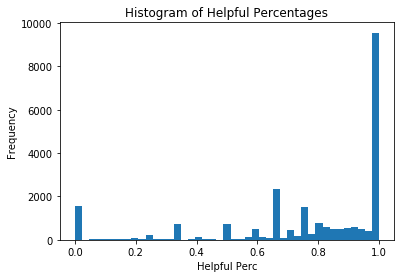

In [13]:
fig2 = plt.figure()
ax2 = fig2.add_subplot(1, 1, 1)
n, bins, patches = ax2.hist(x=df['helpful_perc'], bins='auto')
                                 
ax2.set_xlabel('Helpful Perc')
ax2.set_ylabel('Frequency')
ax2.set_title('Histogram of Helpful Percentages')

## Model 1: Helpful Reviews Are Determined Randomly

In [14]:
# to repeat results
random.seed(12345)

# calculate total number of reviews
total_reviews = len(df)

helpful_perc = df['helpful_perc']

random_helpful = []
for i in range(total_reviews):
    random_helpful.append(random.random())
    

np.corrcoef(helpful_perc, random_helpful)[1,0]

-0.0016068365532971554

## Model 2: Encoded Words and Linear Regression

### Data Pre-Processing

In [15]:
# ensure there are no missing values in the review or summary text or the overall helpullness percentage
len(df) == len(df.dropna(subset=['reviewText', 'summary', 'helpful_perc']))

True

In [16]:
# remove stop words and tokenize
stop_words = set(stopwords.words('english'))

def tokenize(text):
    return [word for word in word_tokenize(text) if not word in stop_words]

In [17]:
# Combine the reviewText and summary text fields to combine into a single "document" with which to analyze
df['combinedText'] = df['summary'].str.lower() + ". " +  df['reviewText'].str.lower()

# Now tokenize these and remove stop words
df['processedText'] = df['combinedText'].apply(tokenize)

In [18]:
# preprocess the data
data = df[['combinedText', 'helpful_perc']]

le = preprocessing.LabelEncoder()
preprocessed_data = data.apply(le.fit_transform)

### Split into Train/Test

In [19]:
Train_X, Test_X, Train_Y, Test_Y = train_test_split(preprocessed_data['combinedText'], 
                                                    preprocessed_data['helpful_perc'],
                                                    random_state = 12345, # reproduce results
                                                    test_size=0.2)

### Instantiate and Train the Model

In [20]:
# instantiate model
regr = linear_model.LinearRegression()

# train the model using the training sets
regr.fit(np.array(Train_X.values.tolist()).reshape(-1, 1), Train_Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

### Predict Test Labels and Score

In [21]:
# predict values
pred = regr.predict(np.array(Test_X.values.tolist()).reshape(-1, 1))

# score with correlation coefficient
np.corrcoef(Test_Y,pred)[1,0]

0.027932312806567966

## Model 3: TF-IDF and Linear Regression

### Split Into Train/Test

In [22]:
# split into train//test sets
data = df[['combinedText', 'helpful_perc']]

df_train, df_test = train_test_split(data, test_size = 0.2, random_state = 12345)

### Data Pre-Processing

In [23]:
# stem combinedText to reduce size of corpus
porter=PorterStemmer()

def stem_text(df):
    text_list = df['combinedText'].tolist()
    text_list_stem = [None] * len(text_list)

    for i in range(len(text_list)):
        text_list_stem[i] = ' '.join([porter.stem(w) for w in text_list[i].split()])
    
    return text_list_stem

text_list_stem = stem_text(data)

In [24]:
# vectorize text
vectorizer = TfidfVectorizer(
                max_features=100,
                ngram_range=(1,1)
                )

vectorizer.fit_transform(text_list_stem).toarray()

array([[0.        , 0.        , 0.        , ..., 0.17713675, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.19837654, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.06237604, 0.03611045, ..., 0.        , 0.15155843,
        0.16257494],
       [0.        , 0.10427993, 0.        , ..., 0.        , 0.0844582 ,
        0.10871678],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [25]:
# vectorize train dataset
train_text_stem = stem_text(df_train)
train_vectorized = vectorizer.transform(train_text_stem).toarray()

print('Shape:', train_vectorized.shape)

Shape: (18827, 100)


In [26]:
# vectorize test dataset
test_text_stem = stem_text(df_test)
test_vectorized = vectorizer.transform(test_text_stem).toarray()

print('Shape:', test_vectorized.shape)

Shape: (4707, 100)


In [27]:
# create array of labels to use in linear regression
df_train_labels = np.array(df_train['helpful_perc'])
df_test_labels = np.array(df_test['helpful_perc'])

### Instantiate and Train the Model

In [28]:
# instantiate model
regr_2 = linear_model.LinearRegression()

# train the model using the training sets
regr_2.fit(np.array(train_vectorized.tolist()), df_train_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

### Predict Test Labels and Score

In [29]:
# predict values
pred_2 = regr_2.predict(np.array(test_vectorized.tolist()))

# score with correlation coefficient
np.corrcoef(df_test_labels, pred_2)[1,0]

0.25494885117229604

## Model 4: BERT

In [29]:
import sys
import os
import re

# if this doesnt work, ensure tensorflow is version <2.0
import tensorflow as tf
import tensorflow_hub as hub

from bert.tokenization import FullTokenizer
from tqdm import tqdm_notebook
from tensorflow.keras import backend as K

# Tensorflow hub path to BERT module of choice
BERT_DIR =  "./bert"
BERT_PATH = "https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1"
MAX_SEQ_LENGTH = 128

sys.path.insert(0,BERT_DIR)

# Initialize session, may need to remove config if no GPU
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

In [30]:
class PaddingInputExample(object):
    """Fake example so the num input examples is a multiple of the batch size.
  When running eval/predict on the TPU, we need to pad the number of examples
  to be a multiple of the batch size, because the TPU requires a fixed batch
  size. The alternative is to drop the last batch, which is bad because it means
  the entire output data won't be generated.
  We use this class instead of `None` because treating `None` as padding
  battches could cause silent errors.
  """

class InputExample(object):
    """A single training/test example for simple sequence classification."""

    def __init__(self, guid, text_a, text_b=None, label=None):
        """Constructs a InputExample.
    Args:
      guid: Unique id for the example.
      text_a: string. The untokenized text of the first sequence. For single
        sequence tasks, only this sequence must be specified.
      text_b: (Optional) string. The untokenized text of the second sequence.
        Only must be specified for sequence pair tasks.
      label: (Optional) string. The label of the example. This should be
        specified for train and dev examples, but not for test examples.
    """
        self.guid = guid
        self.text_a = text_a
        self.text_b = text_b
        self.label = label
        
    def __str__(self):
        return str(self.text_a)

def create_tokenizer_from_hub_module(path):
    """Get the vocab file and casing info from the Hub module."""
    bert_module =  hub.Module(path)
    tokenization_info = bert_module(signature="tokenization_info", as_dict=True)
    vocab_file, do_lower_case = sess.run(
        [
            tokenization_info["vocab_file"],
            tokenization_info["do_lower_case"],
        ]
    )

    return FullTokenizer(vocab_file=vocab_file, do_lower_case=do_lower_case)

def convert_single_example(tokenizer, example, max_seq_length=256):
    """Converts a single `InputExample` into a single `InputFeatures`."""

    if isinstance(example, PaddingInputExample):
        input_ids = [0] * max_seq_length
        input_mask = [0] * max_seq_length
        segment_ids = [0] * max_seq_length
        label = 0
        return input_ids, input_mask, segment_ids, label

    tokens_a = tokenizer.tokenize(example.text_a)
    tokens_b = tokenizer.tokenize(example.text_b)
    
    if len(tokens_a) > max_seq_length - 2:
        tokens_a = tokens_a[0 : (max_seq_length - 2)]

    elif (len(tokens_a)+len(tokens_b)) > max_seq_length - 3:
        tokens_b = tokens_b[0 : (max_seq_length - 3 - len(tokens_a))]
        
    tokens = []
    segment_ids = []
    tokens.append("[CLS]")
    segment_ids.append(0)
    
    for token in tokens_a:
        tokens.append(token)
        segment_ids.append(0)
    tokens.append("[SEP]")
    segment_ids.append(0)

    if len(tokens) < max_seq_length:
        for token in tokens_b:
            tokens.append(token)
            segment_ids.append(1)
        tokens.append("[SEP]")
        segment_ids.append(1)
    
    input_ids = tokenizer.convert_tokens_to_ids(tokens)

    # The mask has 1 for real tokens and 0 for padding tokens. Only real
    # tokens are attended to.
    input_mask = [1] * len(input_ids)

    # Zero-pad up to the sequence length.
    while len(input_ids) < max_seq_length:
        input_ids.append(0)
        input_mask.append(0)
        segment_ids.append(0)

    assert len(input_ids) == max_seq_length
    assert len(input_mask) == max_seq_length
    assert len(segment_ids) == max_seq_length

    return input_ids, input_mask, segment_ids, example.label

def convert_examples_to_features(tokenizer, examples, max_seq_length=256):
    """Convert a set of `InputExample`s to a list of `InputFeatures`."""

    input_ids, input_masks, segment_ids, labels = [], [], [], []
    for example in tqdm_notebook(examples, desc="Converting examples to features"):
        input_id, input_mask, segment_id, label = convert_single_example(
            tokenizer, example, max_seq_length
        )
        input_ids.append(input_id)
        input_masks.append(input_mask)
        segment_ids.append(segment_id)
        labels.append(label)
    return (
        np.array(input_ids),
        np.array(input_masks),
        np.array(segment_ids),
        np.array(labels).reshape(-1, 1),
    )

def convert_text_to_examples(titles, texts, labels, max_examples=None):
    """Create InputExamples"""
    InputExamples = []
    for title, text, label in zip(titles, texts, labels):
        InputExamples.append(
            InputExample(guid=None, text_a=title, text_b=text, label=label)
        )
    return InputExamples[:max_examples]

In [31]:
# Instantiate tokenizer
tokenizer = create_tokenizer_from_hub_module(BERT_PATH)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [33]:
# process df - only reviews that have 0 or 100% ratings and at least 10 reviews
df = ones_and_zeroes_df(df)
df = df.drop(df[df.total_votes < 10].index)

404


In [35]:
# split into train and test
df_train, df_test = train_test_split(df, test_size = 0.2)
df_train, df_val = train_test_split(df_train, test_size = 0.2)

In [36]:
# Convert data to InputExample format, ensure we don't have too many examples to encounter memory issues
train_examples = convert_text_to_examples(df_train['summary'], df_train['reviewText'], df_train['helpful_perc'], max_examples=10000)
val_examples = convert_text_to_examples(df_val['summary'], df_val['reviewText'], df_val['helpful_perc'], max_examples=2000)
test_examples = convert_text_to_examples(df_test['summary'], df_test['reviewText'], df_test['helpful_perc'], max_examples=2000)

#make sure the test Y is the same format
test_actual = np.array(df_test['helpful_perc'][:2000])
test_actual = test_actual.reshape(-1,1)

# Convert to features
(train_input_ids, train_input_masks, train_segment_ids, train_labels 
) = convert_examples_to_features(tokenizer, train_examples, max_seq_length=MAX_SEQ_LENGTH)
(val_input_ids, val_input_masks, val_segment_ids, val_labels 
) = convert_examples_to_features(tokenizer, val_examples, max_seq_length=MAX_SEQ_LENGTH)
(test_input_ids, test_input_masks, test_segment_ids, test_labels
) = convert_examples_to_features(tokenizer, test_examples, max_seq_length=MAX_SEQ_LENGTH)

In [38]:
# create neural net
class BertLayer(tf.keras.layers.Layer):
    def __init__(
        self,
        n_fine_tune_layers=10,
        pooling="first",
        bert_path="https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1",
        **kwargs,
    ):
        self.n_fine_tune_layers = n_fine_tune_layers
        self.trainable = True
        self.output_size = 768
        self.pooling = pooling
        self.bert_path = bert_path
        if self.pooling not in ["first", "mean"]:
            raise NameError(
                f"Undefined pooling type (must be either first or mean, but is {self.pooling}"
            )

        super(BertLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.bert = hub.Module(
            self.bert_path, trainable=self.trainable, name=f"{self.name}_module"
        )

        # Remove unused layers
        trainable_vars = self.bert.variables
        if self.pooling == "first":
            trainable_vars = [var for var in trainable_vars if not "/cls/" in var.name]
            trainable_layers = ["pooler/dense"]

        elif self.pooling == "mean":
            trainable_vars = [
                var
                for var in trainable_vars
                if not "/cls/" in var.name and not "/pooler/" in var.name
            ]
            trainable_layers = []
        else:
            raise NameError(
                f"Undefined pooling type (must be either first or mean, but is {self.pooling}"
            )

        # Select how many layers to fine tune
        for i in range(self.n_fine_tune_layers):
            trainable_layers.append(f"encoder/layer_{str(11 - i)}")

        # Update trainable vars to contain only the specified layers
        trainable_vars = [
            var
            for var in trainable_vars
            if any([l in var.name for l in trainable_layers])
        ]

        # Add to trainable weights
        for var in trainable_vars:
            self._trainable_weights.append(var)

        for var in self.bert.variables:
            if var not in self._trainable_weights:
                self._non_trainable_weights.append(var)

        super(BertLayer, self).build(input_shape)

    def call(self, inputs):
        inputs = [K.cast(x, dtype="int32") for x in inputs]
        input_ids, input_mask, segment_ids = inputs
        bert_inputs = dict(
            input_ids=input_ids, input_mask=input_mask, segment_ids=segment_ids
        )
        if self.pooling == "first":
            pooled = self.bert(inputs=bert_inputs, signature="tokens", as_dict=True)[
                "pooled_output"
            ]
        elif self.pooling == "mean":
            result = self.bert(inputs=bert_inputs, signature="tokens", as_dict=True)[
                "sequence_output"
            ]

            mul_mask = lambda x, m: x * tf.expand_dims(m, axis=-1)
            masked_reduce_mean = lambda x, m: tf.reduce_sum(mul_mask(x, m), axis=1) / (
                    tf.reduce_sum(m, axis=1, keepdims=True) + 1e-10)
            input_mask = tf.cast(input_mask, tf.float32)
            pooled = masked_reduce_mean(result, input_mask)
        else:
            raise NameError(f"Undefined pooling type (must be either first or mean, but is {self.pooling}")

        return pooled

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_size)
    
    def get_config(self):
        config = {'n_fine_tune_layers': self.n_fine_tune_layers,
                  'pooling': self.pooling,
                  'bert_path': self.bert_path}
        base_config = super(MyMeanPooling, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [39]:
from tensorflow.keras import regularizers

# Build model
def build_model(max_seq_length, model_loss, reg=False): 

    in_id = tf.keras.layers.Input(shape=(max_seq_length,), name="input_ids")
    in_mask = tf.keras.layers.Input(shape=(max_seq_length,), name="input_masks")
    in_segment = tf.keras.layers.Input(shape=(max_seq_length,), name="segment_ids")
    bert_inputs = [in_id, in_mask, in_segment]

    bert_output = BertLayer(n_fine_tune_layers=3, pooling="first")(bert_inputs)
    if reg:
        dense = tf.keras.layers.Dense(max_seq_length, activation='relu', kernel_regularizer=regularizers.l2(0.01))(bert_output)
    else:
        dense = tf.keras.layers.Dense(max_seq_length, activation='relu')(bert_output)
    pred = tf.keras.layers.Dense(1, activation='sigmoid')(dense)

    model = tf.keras.models.Model(inputs=bert_inputs, outputs=pred)
    model.compile(loss=model_loss, optimizer='adam')
    model.summary()
    
    return model

def initialize_vars(sess):
    sess.run(tf.local_variables_initializer())
    sess.run(tf.global_variables_initializer())
    sess.run(tf.tables_initializer())
    K.set_session(sess)

In [41]:
# build the model
#BCE Model: using BCE in regression https://stats.stackexchange.com/questions/370179/why-binary-crossentropy-can-be-used-as-the-loss-function-in-autoencoders/370180#370180
model_RMSE_reg = build_model(MAX_SEQ_LENGTH, 'mean_squared_error', reg=True)

# Instantiate variables
initialize_vars(sess)

model_RMSE_reg.fit(
    [train_input_ids, train_input_masks, train_segment_ids], 
    train_labels,
    validation_data=([val_input_ids, val_input_masks, val_segment_ids], val_labels),
    epochs=3,
    batch_size=4
)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        [(None, 128)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 128)]        0                                            
__________________________________________________________________________________________________
bert_layer_2 (BertLayer)        (None, 768)          110104890   input_ids[0][0]                  
                                                                 input_masks[0][0]          

In [42]:
# save weights
model_RMSE_reg.save_weights('./models/model_RMSE_reg')

In [43]:
# test the model's predictions
preds_RMSE_reg = model_RMSE_reg.predict([test_input_ids, test_input_masks, test_segment_ids])
np.corrcoef(preds_RMSE_reg.T, test_actual.T)

array([[ 1.        , -0.03421395],
       [-0.03421395,  1.        ]])